In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import matplotlib.animation as animation
%matplotlib notebook

# Tetris AI Survey

This notebook explores different strategies of implementing an AI to play Tetris.
The goal of the AI is to clear as many lines as possible before losing.

> Note: Still WIP

## 1-piece Tetris

1-piece Tetris is a simple variant of Tetris game:
- The player only knows about 1 piece at a time (more popular variants allow few pieces lookahead, and also allows swapping pieces)
- The piece drops straight down, so fancy moves like T-spins and overhangs are not allowed

In [232]:
Piece = namedtuple('Piece', ['id', 'name', 'array'])
DropMove = namedtuple('DropMove', ['col', 'rot'])
Move = namedtuple('Move', ['piece', 'row', 'col', 'rot'])

class InvalidMove(ValueError):
    def __init__(self):
        self.message = 'invalid move'

class GameOver(ValueError):
    def __init__(self):
        self.message = 'game over'

# Helper methods for solver

def rotate(piece, k=1):
    return Piece(piece.id, piece.name, np.rot90(piece.array.copy(), k))

def translate(piece, row, col):
    (h, w) = piece.shape
    if col+w > 10 or row+h > 20:
        raise Exception('out of bound')

    if col > 0:
        mask = np.concatenate((np.zeros((h,col), dtype=int), piece), axis=1)
        mask = np.concatenate((mask, np.zeros((h,10-w-col), dtype=int)), axis=1)
    else:
        mask = np.concatenate((piece, np.zeros((h,10-w), dtype=int)), axis=1)

    if row > 0:
        mask = np.concatenate((np.zeros((row,10), dtype=int), mask), axis=0)
        mask = np.concatenate((mask, np.zeros((20-h-row,10), dtype=int)), axis=0)
    else:
        mask = np.concatenate((mask, np.zeros((20-h,10), dtype=int)), axis=0)

    return mask

def drop(board, piece, col):
    (h, w) = piece.shape
    if col+w > 10:
        raise InvalidMove()

    drop_row = -1
    for row in range(20-h+1):
        result = board + translate(piece, row, col)
        if 2 in result:
            break
        drop_row = row

    if drop_row < 0:
        raise GameOver()
    return (board + translate(piece, drop_row, col), drop_row)

def clear_lines(board):
    sums = np.sum(board > 0, axis=1)
    lines_cleared = np.sum(sums == 10)

    if lines_cleared > 0:
        return (np.concatenate((np.zeros((lines_cleared,10), dtype=int), board[sums != 10]), axis=0), lines_cleared)

    return (board, lines_cleared)

class Game(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.board = np.zeros((20, 10), dtype=int)
        self.colored_board = np.zeros((20, 10), dtype=int)
        self.pieces = 0
        self.lines_cleared = 0
        self.last_move = None
        
        self.pieces_bag = []
        self.generate_next_pieces()
        
    def generate_next_pieces(self):
        i = Piece(1, 'I', np.array([[1, 1, 1, 1]]))
        o = Piece(2, 'O', np.array([[1, 1], [1, 1]]))
        t = Piece(3, 'T', np.array([[1, 1, 1], [0, 1, 0]]))
        j = Piece(4, 'J', np.array([[1, 0, 0], [1, 1, 1]]))
        l = Piece(5, 'L', np.array([[0, 0, 1], [1, 1, 1]]))
        s = Piece(6, 'S', np.array([[0, 1, 1], [1, 1, 0]]))
        z = Piece(7, 'Z', np.array([[1, 1, 0], [0, 1, 1]]))
        
        pieces = [i, o, t, j, l, s, z]
        self.rng.shuffle(pieces)
        self.pieces_bag += pieces
    
    def tick(self, play):
        piece = self.pieces_bag.pop(0)
        
        # Update the state
        try:
            # Copy the board and piece to prevent cheating
            move = play(self.board.copy(), Piece(piece.id, piece.name, piece.array.copy()))
            
            # If player ran out of move, game over
            if move is None:
                raise GameOver()
            
            (updated, drop_row) = drop(self.board, rotate(piece, move.rot).array, move.col)
            (updated, lines) = clear_lines(updated)
        
            self.board = updated
            self.lines_cleared += lines
            self.pieces += 1
            self.last_move = Move(piece, drop_row, move.col, move.rot)
            
            colored = translate(rotate(piece, move.rot).array, drop_row, move.col)
            colored[colored == 1] = piece.id
            self.colored_board += colored
            (self.colored_board, lines) = clear_lines(self.colored_board)

            if len(self.pieces_bag) == 0:
                self.generate_next_pieces()
                
            return True
                
        except InvalidMove as e:
            self.pieces_bag.insert(0, piece)
            return False
    
    def draw(self, ax0=None, ax1=None, im0=None, im1=None):
        palette = np.array([
            [127, 127, 127],
            [0, 255, 255],
            [255, 255, 0],
            [128, 0, 128],
            [0, 255, 0],
            [255, 0, 0],
            [0, 0, 255],
            [255, 127, 9]
        ])
            
        if ax0 is None and im0 is None:
            gs_kw = dict(width_ratios=[8, 1], height_ratios=[3, 8])
            fig, ax = plt.subplot_mosaic([[0, 1], [0, 2]],
                              gridspec_kw=gs_kw,
                              constrained_layout=True)
        
            im0 = ax[0].imshow(palette[self.colored_board])
            
            ax[0].set_title('pieces = {0:8}, cleared={1:8}'.format(self.pieces, self.lines_cleared))

            ax[0].set_xticks(np.arange(0, 10, 1))
            ax[0].set_yticks(np.arange(0, 20, 1))

            ax[0].set_xticks(np.arange(-.5, 10, 1), minor=True)
            ax[0].set_yticks(np.arange(-.5, 20, 1), minor=True)

            ax[0].grid(which='minor', color='#7f7f7f', linestyle='-', linewidth=2)
            
            if self.last_move is None:
                piece = np.zeros((2, 4), dtype=int)
            else:
                piece = self.last_move.piece.array.copy()
                if piece.shape[1] < 4:
                    piece = np.concatenate((piece, np.zeros((piece.shape[0], 4-piece.shape[1]), dtype=int)), axis=1)
                if piece.shape[0] < 2:
                    piece = np.concatenate((piece, np.zeros((2-piece.shape[0], 4), dtype=int)), axis=0)
                piece[piece == 1] = self.last_move.piece.id
                
                ax[1].set_title('piece = {0}'.format(self.last_move.piece.name))
            
            im1 = ax[1].imshow(palette[piece])
            
            pos1 = ax[1].get_position()
            pos2 = [pos1.x0 - 0.1, pos1.y0,  pos1.width, pos1.height] 
            ax[1].set_position(pos2) 
            
            ax[1].set_xticks(np.arange(0, 4, 1))
            ax[1].set_yticks(np.arange(0, 2, 1))

            ax[1].set_xticks(np.arange(-.5, 4, 1), minor=True)
            ax[1].set_yticks(np.arange(-.5, 2, 1), minor=True)
            
            ax[1].grid(which='minor', color='#7f7f7f', linestyle='-', linewidth=2)
            
            ax[2].axis('off')
            
            return [fig, ax[0], ax[1], im0, im1]
        else:
            ax0.set_title('pieces = {0:8}, cleared={1:8}'.format(self.pieces, self.lines_cleared))
            im0.set_array(palette[self.colored_board])
            
            piece = self.last_move.piece.array
            if piece.shape[1] < 4:
                piece = np.concatenate((piece, np.zeros((piece.shape[0], 4-piece.shape[1]), dtype=int)), axis=1)
            if piece.shape[0] < 2:
                piece = np.concatenate((piece, np.zeros((2-piece.shape[0], 4), dtype=int)), axis=0)
            piece[piece == 1] = self.last_move.piece.id
            
            ax1.set_title('piece = {0}'.format(self.last_move.piece.name))
            im1.set_array(palette[piece])

In [216]:
def animate_game(seed, player, iters, interval=50):
    game = Game(seed)

    fig, ax0, ax1, im0, im1 = game.draw()
    
    def init():
        return True

    def tick(frame, *args):
        game.tick(player)
        game.draw(ax0, ax1, im0, im1)
        return im

    ani = animation.FuncAnimation(fig, tick, frames=iters, init_func=init, interval=interval, repeat=False)
    return [game, ani]

## Simplest AI

The simplest AI is one that just drops the piece at column 0 with no rotation every time.

<IPython.core.display.Javascript object>


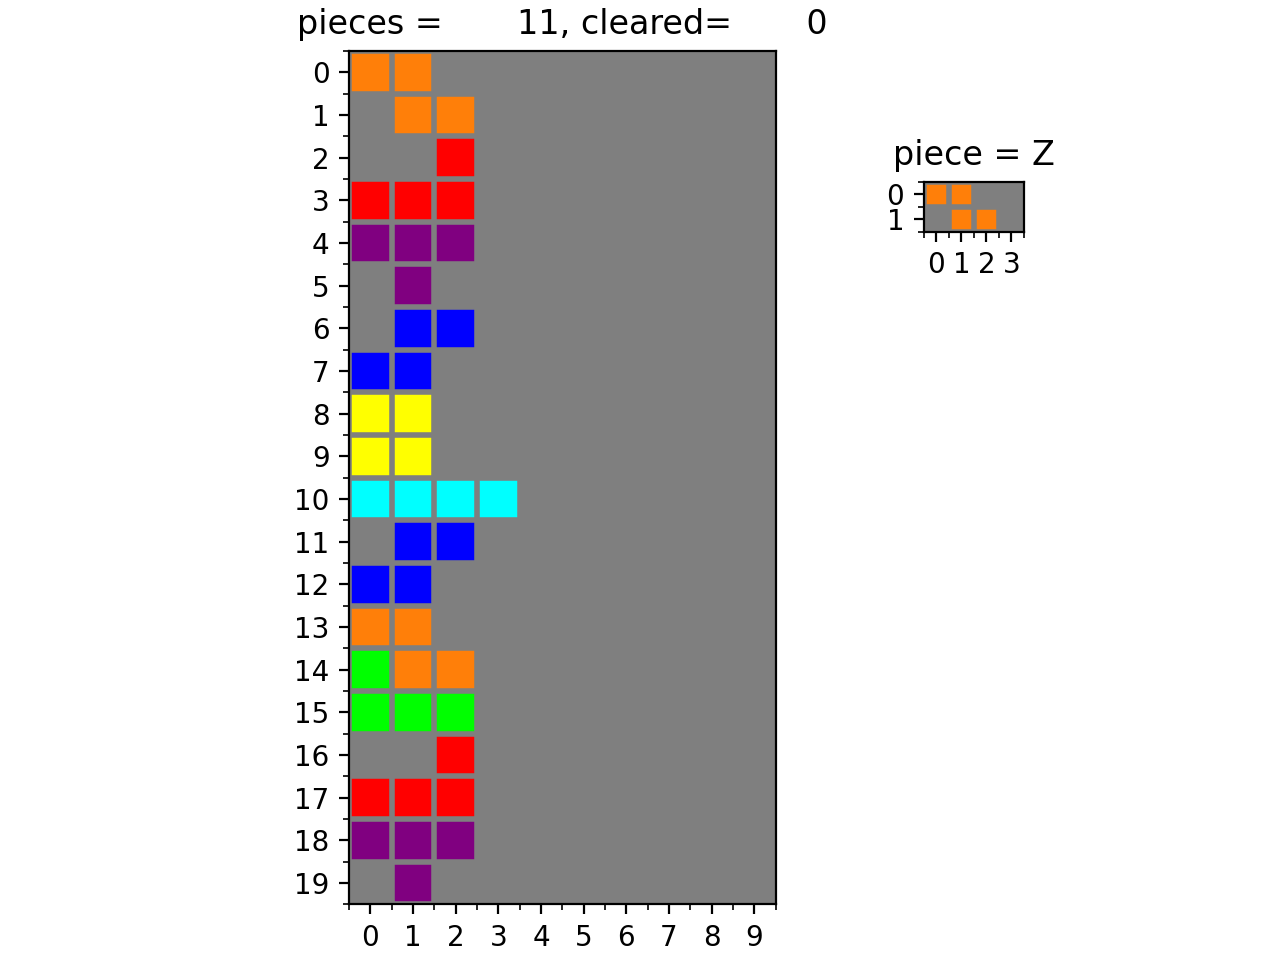

In [217]:
def dummy(board, piece):
    return DropMove(rot=0, col=0)

game, ani = animate_game(0, dummy, 100)

## Random AI

Another simple AI is one that picks a random column and rotation.

<IPython.core.display.Javascript object>


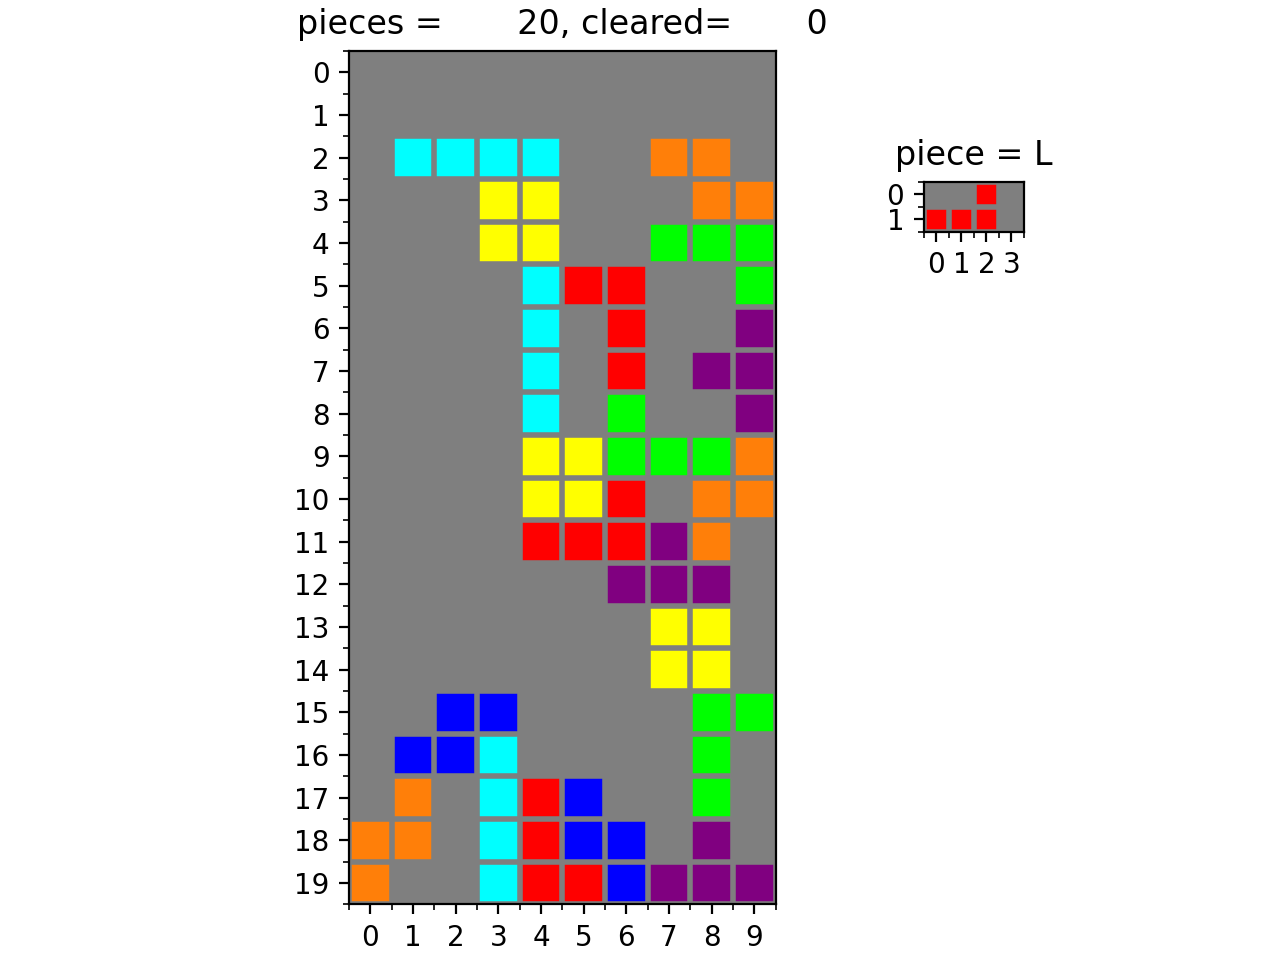

In [218]:
rng = np.random.default_rng(4)

def random_play(board, piece):
    rot = rng.integers(4)
    p = np.rot90(piece.array, rot)
    w = p.shape[1]
    
    col = rng.integers(board.shape[1] - w + 1)
    return DropMove(rot=rot, col=col)

game, ani = animate_game(0, random_play, 100)

## El-Tetris

El-Tetris is an algorithm designed by [Islam El-Ashi](https://imake.ninja/el-tetris-an-improvement-on-pierre-dellacheries-algorithm/). It's allegedly the best algorithm for 1-piece tetris, clearing an average of 16 million lines per game.

The algorithm is quite simple. For each possible move, it calculates a score, which is a weighted sum of the following features:

- Landing height
- Lines cleared
- Row transitions
- Column transitions
- Number of holes
- Well sums

The weight assigned to each of these features have been pre-calculated using PSO (Particle Swarm Optimization).

In [45]:
def landing_height(board, move):
    return move.row + (move.piece.shape[0]-1)/2

def row_transitions(board):
    transitions = 0
    
    for row in board:
        d = np.diff(row) != 0
        idx = np.concatenate(([0], np.flatnonzero(d) + 1))
        c = np.diff(np.concatenate((idx, [len(row)])))
        transitions += len(c)-1
        
    return transitions

def col_transitions(board):
    return row_transitions(np.rot90(board.copy(), k=3))

def holes(board):
    holes = 0
    for row in np.rot90(board.copy(), k=3):
        d = np.diff(row) != 0
        idx = np.concatenate(([0], np.flatnonzero(d) + 1))
        v = row[idx].copy()
        if v[len(v)-1] == 0:
            v[len(v)-1] = 1
            
        holes += len(v[v == 0])
    return holes

def well_sums(board):
    sums = 0
    
    rotated = np.rot90(board.copy(), k=3)
    
    for i in range(rotated.shape[0]):
        row = rotated[i]
        d = np.diff(row) != 0
        idx = np.concatenate(([0], np.flatnonzero(d) + 1))
        v = row[idx]
        c = np.diff(np.concatenate((idx, [len(row)])))
        if v[len(v)-1] == 0:
            well_idx = sum(c[:len(c)-1])

            arr = row[well_idx:].copy()
            target = 0
            if i-1 >= 0:
                arr += rotated[i-1][well_idx:]
                target += 1
            if i+1 < rotated.shape[0]:
                arr += rotated[i+1][well_idx:]
                target += 1

            d = np.diff(arr) != 0
            idx = np.concatenate(([0], np.flatnonzero(d) + 1))
            v = arr[idx]
            c = np.diff(np.concatenate((idx, [len(arr)])))

            if v[0] == target:
                sums += np.arange(1, c[0]+1).sum()

    return sums
        
def evaluate_board(board, piece, move):
    piece = rotate(piece, move.rot)
    (updated, drop_row) = drop(board, piece.array, move.col)
    (updated, lines_cleared) = clear_lines(updated)
    
    landing_height = board.shape[0]-drop_row + ((piece.array.shape[0]-1)/2)
    
    return np.array([
        landing_height * -4.500158825082766,
        lines_cleared * 3.4181268101392694,
        row_transitions(updated) * -3.2178882868487753,
        col_transitions(updated) * -9.348695305445199,
        holes(updated) * -7.899265427351652,
        well_sums(updated) * -3.3855972247263626,
    ]).sum()

def enumerate_moves(board, piece):
    rots = [0]
    for k in range(1, 4):
        rotated = rotate(piece, k)
        unique = True
        for rot in rots:
            if np.array_equal(rotated.array, rotate(piece, rot).array):
                unique = False
                break
                
        if unique:
            rots.append(k)
        else:
            break
    
    for rot in rots:
        rotated = rotate(piece, rot)
        for col in range(board.shape[1]-rotated.array.shape[1]+1):
            yield DropMove(col, rot)

<IPython.core.display.Javascript object>


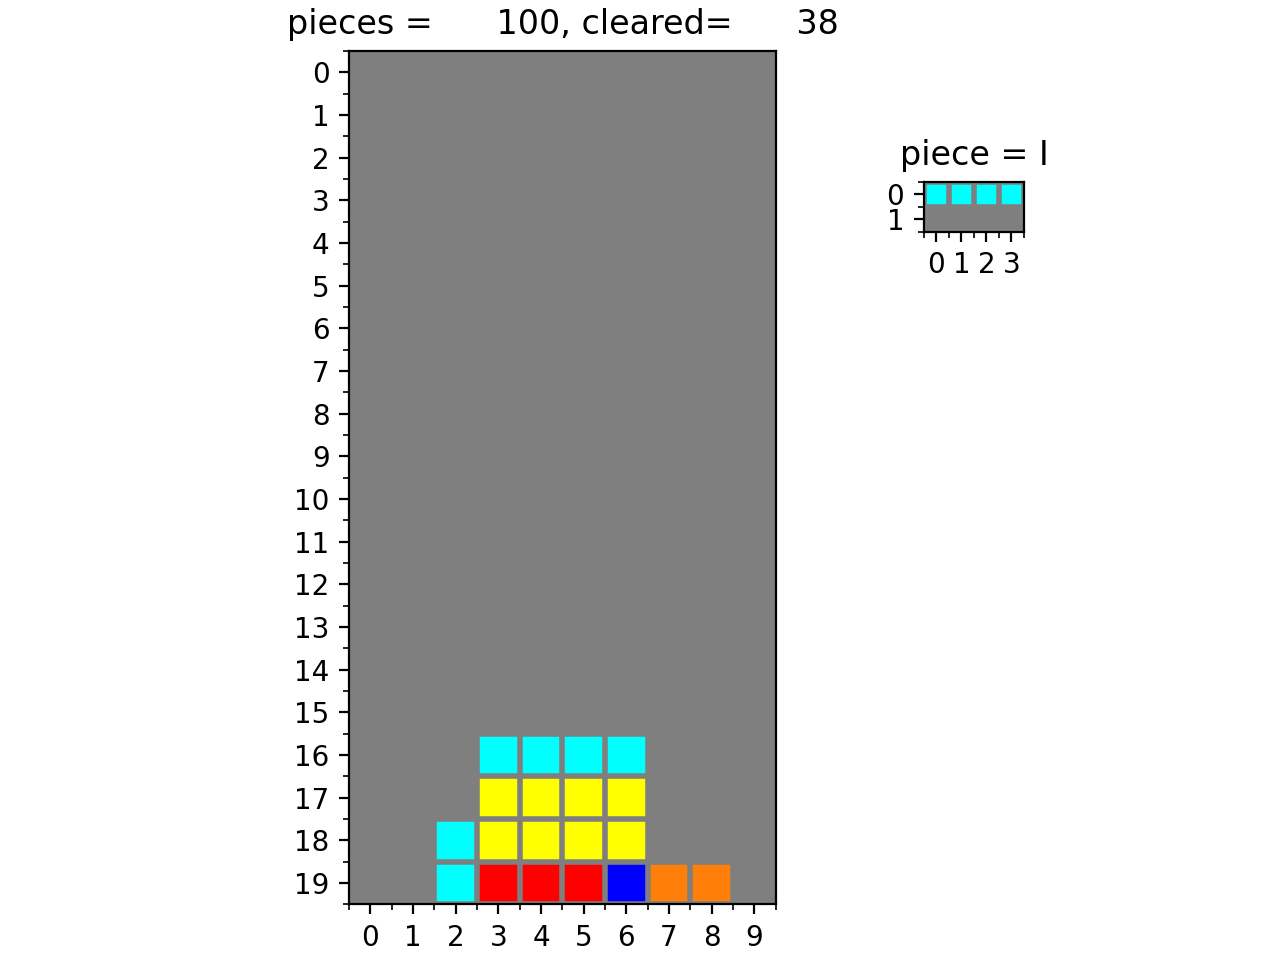

In [234]:
def el_tetris(board, piece):
    best_score = -10000000000000000.
    best_move = None
    
    for move in enumerate_moves(board, piece):
        try:
            score = evaluate_board(board, piece, move)
            if score > best_score:
                best_score = score
                best_move = move
        except GameOver as e:
            continue
    
    return best_move

game, ani = animate_game(0, el_tetris, 100, interval=1)